# Regime Diagnostics

This notebook takes the fitted HMM and labeled series from the previous step and analyzes how the inferred regimes behave over time. It applies a light smoothing to the state sequence, examines transition behavior and streak lengths, projects the regimes into a low-dimensional space, and writes out a compact diagnostics report.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import warnings

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')

DATA_PATH = '../data/processed/rubiks_times_series.csv'
MODEL_PATH = '../models/hmm_gaussian.pkl'
SCALER_PATH = '../models/hmm_scaler.pkl'

In [32]:
df = pd.read_csv(DATA_PATH)
hmm_model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

X_features = df[['time_sec', 'volatility_5']].values
X_scaled = scaler.transform(X_features)


The raw HMM predictions can jump on isolated solves because individual outliers in timing or volatility can momentarily resemble another state. A small rolling majority rule is applied to remove these one-off flips. Smoothing is only meant to correct isolated noise, not to reshape longer trends, so the window is kept intentionally short.

In [33]:
def smooth_states(series, window=3):
    """
    Applies a rolling 'Majority Vote' to filter out single-solve noise.
    Example: [Flow, Baseline, Flow] -> [Flow, Flow, Flow]
    """
    return series.rolling(window=window, center=True).apply(
        lambda x: x.mode()[0] 
    ).fillna(series)

df['state_smooth'] = smooth_states(df['state_id'])
df['state_smooth'] = df['state_smooth'].astype(int)

df['state_id'] = df['state_smooth']

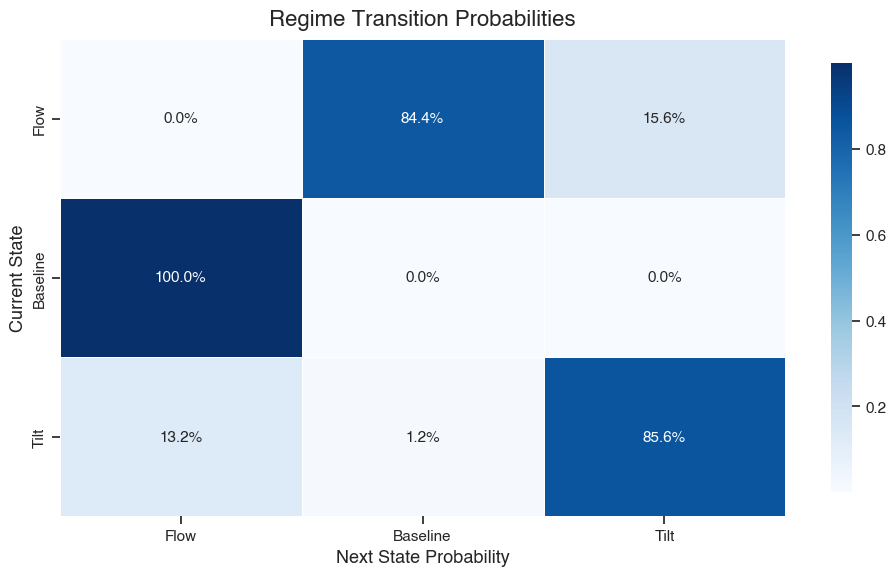

Tilt Stickiness:   85.6%
Overall Stability:  40.4%


In [34]:
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "Helvetica",
})

trans_mat = hmm_model.transmat_

fig, ax = plt.subplots()

sns.heatmap(
    trans_mat,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    linewidths=0.5,
    linecolor="white",
    xticklabels=["Flow", "Baseline", "Tilt"],
    yticklabels=["Flow", "Baseline", "Tilt"],
    cbar_kws={"shrink": 0.9},
    annot_kws={"fontsize": 11},
    ax=ax,
)

ax.set_title("Regime Transition Probabilities", pad=10)
ax.set_ylabel("Current State")
ax.set_xlabel("Next State Probability")

fig.tight_layout()
fig.savefig("../results/transition_matrix.png", dpi=300)
plt.show()

empirical_stability = (df["state_id"] == df["state_id"].shift(-1)).mean()
tilt_prob = trans_mat[2, 2]

print(f"Tilt Stickiness:   {tilt_prob:.1%}")
print(f"Overall Stability:  {empirical_stability:.1%}")

The transition matrix shows how the model expects regimes to evolve from solve to solve. Because it was trained in scaled feature space, the persistence of each state reflects how tightly the model believes the observations cluster within that regime. Flow and Tilt show strong self-persistence, while Baseline does not, which hints that Baseline is functioning more as a boundary region than a regime that tends to continue. The stability is computed alongside the matrix to compare these learned transitions with how often the actual sequence stays in the same state, indicating that I seem to get trapped in poor performance during the tilt states compared to the others.

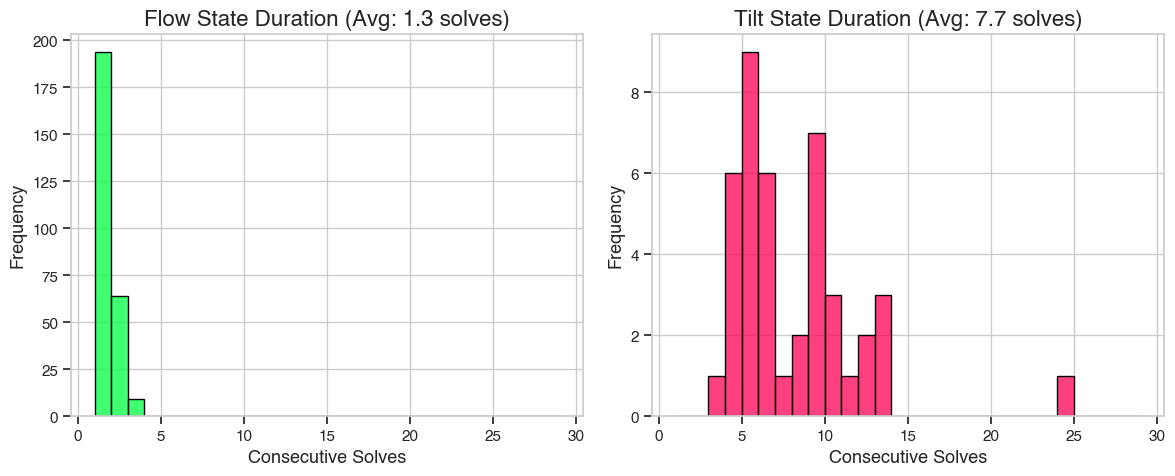

In [35]:
def calculate_dwell_times(states):
    dwell_times = {0: [], 1: [], 2: []}
    current_state = states[0]
    count = 0
    
    for state in states:
        if state == current_state:
            count += 1
        else:
            dwell_times[current_state].append(count)
            current_state = state
            count = 1
    dwell_times[current_state].append(count)
    return dwell_times

dwells = calculate_dwell_times(df['state_id'].values)

FLOW_COLOR = "#00FF41"
TILT_COLOR = "#FF0055"

dwells = calculate_dwell_times(df["state_id"].values)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    dwells[0],
    bins=range(1, 30),
    color=FLOW_COLOR,
    kde=False,
    ax=axes[0]
)
axes[0].set_title(f"Flow State Duration (Avg: {np.mean(dwells[0]):.1f} solves)")
axes[0].set_xlabel("Consecutive Solves")
axes[0].set_ylabel("Frequency")

sns.histplot(
    dwells[2],
    bins=range(1, 30),
    color=TILT_COLOR,
    kde=False,
    ax=axes[1]
)
axes[1].set_title(f"Tilt State Duration (Avg: {np.mean(dwells[2]):.1f} solves)")
axes[1].set_xlabel("Consecutive Solves")
axes[1].set_ylabel("Frequency")

plt.tight_layout()

fig.savefig("../results/dwell_time_distribution.png", dpi=300)

plt.show()


Dwell times measure how long the model keeps you in a regime before switching, allowing us to see the typical “run length” of Flow or Tilt episodes. Flow tends to appear in short bursts, while Tilt events last longer and have a wider spread. This asymmetry is visible in the histograms: Flow dissolves quickly, whereas Tilt clusters into multi-solve stretches. These patterns usually reflect that unstable periods create more internally consistent behavior than fast ones, so the model treats them as extended regimes. This confirms what I stated in the previous markdown, essentially showing the tilt state is harder to get out of.

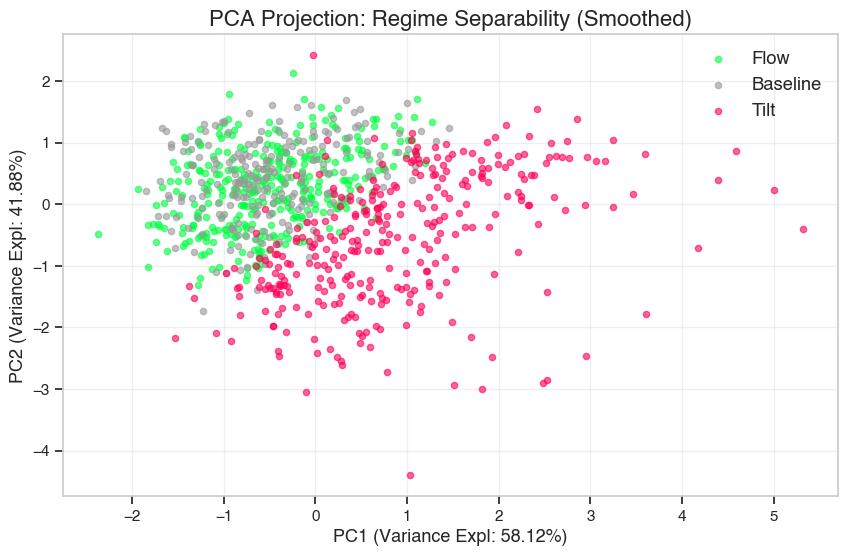

In [36]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
colors = ['#00FF41', '#999999', '#FF0055'] 
labels = ['Flow', 'Baseline', 'Tilt']

for i in range(3):
    mask = df['state_id'] == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=colors[i], label=labels[i], alpha=0.6, s=20)

plt.title("PCA Projection: Regime Separability (Smoothed)")
plt.xlabel(f"PC1 (Variance Expl: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 (Variance Expl: {pca.explained_variance_ratio_[1]:.2%})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("../results/pca_regime_projection.png", dpi=300)
plt.show()

A PCA projection is used to see how the regimes separate when reduced to two dimensions. Although the states were learned from standardized solve time and rolling volatility, PCA helps visualize the geometric structure the HMM learned. Flow and Tilt fall into distinct regions, while Baseline fills the space in between. The smoothed labels produce clearer boundaries than the unsmoothed version, which matches the idea that Baseline is a transitional zone rather than a stable cluster.